In [6]:
from IPython.display import display, Latex, Math, Markdown
import numpy as np
import sympy as sym
import matplotlib
import matplotlib.pyplot as plt
from fractions import gcd
from functools import reduce
%matplotlib inline
sym.init_printing()

def printltx(s):
    try: 
        display(Latex(s))
    except: 
        print(s)
def ltxmtx(A, axis = 1):
        try: 
            if isinstance(A, np.ndarray):
                A = A.round(4)
            M = sym.Matrix(A)
            sh = np.array(M.shape)
            sz = np.prod(sh)
            if sz == np.max(sh):
                if axis == 0:
                    M=M.reshape(sz,1)
                else:
                    M=M.reshape(1,sz)
            return " $"+ sym.latex(M) + "$ "
        except: 
            return A
        
array_f = get_ipython().display_formatter.formatters['text/latex']
array_f.for_type('numpy.ndarray',ltxmtx)
array_f.for_type('sympy.matrices.dense.MutableDenseMatrix', ltxmtx)

<function __main__.ltxmtx>

In [7]:
def compute_absorbed(v, States_in_Recurence=[]):
    if States_in_Recurrence == []:
        ap = [1,0]
    else:
        ap = [np.sum(v[states] for states in States_in_Recurrence)]
    return np.array(ap)


def plot_absorption(absorbed_proportions, Tolerance):
    absorbed_proportions = np.array(absorbed_proportions)
    absorbed_cumulative = np.sum(absorbed_proportions,axis=1) #total absorbed by all recurrence classes
    absorbed_cumulative = absorbed_cumulative[absorbed_cumulative<1-Tolerance] #Remove tail, if simulation continued to run after complete absorption
    absorbed_cumulative = np.append(absorbed_cumulative,1.0) #append 1.0 to end
    absorbed_marginal = np.diff(absorbed_cumulative) #find "newly" absorbed proportion at each step
    absorbed_marginal = np.insert(absorbed_marginal,0,absorbed_cumulative[0]) #np.diff shrinks array by 1 entry.  Prepend 0.0
    times = np.arange(absorbed_marginal.shape[0])
    printltx(r"Absorbed proportions (by recurrence class) "+ltxmtx(absorbed_proportions[-1]))
    plt.bar(times,absorbed_marginal)
    plt.show()
    ave = absorbed_marginal.dot(times)
    printltx(r"Mean absorption time is "+str(ave))
    return
  
##############
###METHOD 1###
##############    
    
def simulate_samples(P,phi,Steps,Records,Samples, States_in_Recurrence, Tolerance):
    States = P.shape[0]
    print("\n")
    printltx(r"Begin the First Method")
    printltx(r"Simulating "+str(Steps)+" steps with "+str(Samples)+" samples.")
    epdf = np.zeros([Records, States], dtype = float)
    epdf[0,:] = phi[:]
    
    ap = compute_absorbed(phi, States_in_Recurrence)
    absorbed_proportions = [ap]
    
    y = np.rint(phi*Samples).astype(int)
    Samples = np.sum(y)
    X = np.zeros([Records,Samples], dtype = int)
    X[0,:] = np.random.choice(States, Samples, p=phi)
    
    startStep = 0
    
    while (startStep < Steps | (np.sum(ap) < 1-Tolerance)):
        current_step = startStep%Records 
        next_step = (startStep+1)%Records
        for samp in range(Samples):
            current_state = X[current_step,samp]
            r = np.random.rand()
            for next_state in range(States):
                r -= P[current_state, next_state]
                if r < 0:
                    X[next_step, samp] = next_state
                    break 
            v = np.histogram(X[next_step, :], normed=True, bins=range(States+1))[0]
            epdf[next_step,:] = v
        ap = compute_absorbed(v, States_in_Recurrence)
        absorbed_proportions.append(ap)
        startStep+=1
    epdf = np.roll(epdf,Records-next_step-1,axis=0)
    printltx(r"I did "+str(Steps)+" steps with "+str(Samples)+" samples. The last "+str(Records)+" distributions are written as rows below.")
    display(epdf)
    printltx(r"The average of these distributions is "+ltxmtx(np.mean(epdf,0)))
    plot_absorption(absorbed_proportions, Tolerance=Tolerance)
    return 

    
##############
###METHOD 2###
##############
def matrix_evolution(P, phi, Steps, Records, States_in_Recurrence, Tolerance):
    States = P.shape[0]
    print("\n")
    printltx(r"Begin the Second Method")
    printltx(r"Evolving "+str(Steps)+" steps via matrix multiplication.")
    tpdf = np.zeros([Records,States], dtype = float)
    tpdf[0,:] = phi[:]
    ap = compute_absorbed(phi, States_in_Recurrence)
    absorbed_proportions = [ap]
    startStep = 0           
    while (startStep < Steps) | (np.sum(ap) < 1-Tolerance): 
        current_step = startStep%Records
        next_step = (startStep+1)%Records
        tpdf[next_step,:] = tpdf[current_step,:].dot(P)
                             
        ap = compute_absorbed(tpdf[next_step, :], States_in_Recurrence)
        absorbed_proportions.append(ap)
        startStep += 1
           
    tpdf = np.roll(tpdf, Records-next_step-1,axis=0)
    printltx(r"I did "+str(Steps)+" steps. The last "+str(Records)+" distributions are written as rows below.")
    display(tpdf)
    printltx(r"The average of these distributions is "+ltxmtx(np.mean(tpdf,0)))
    plot_absorption(absorbed_proportions,Tolerance=Tolerance)
    return


    
##############
###METHOD 3###
##############


def support(vec):
    return np.nonzero(vec)[0]    

def normalize_vec(vec):
    Tolerance = 0.001
    s = np.sum(vec)
    if np.abs(s)<Tolerance:
        s = vec[support(vec)][0]
    return vec/s

def normalize_rows(P):
    return np.apply_along_axis(normalize_vec,1,P)
    
def eigen_future(P,phi):
    States = P.shape[0]
    print("\n")
    printltx(r"Using eigenvectors and eigenvalues to find long term behavior.")
    (evals,LT) = np.linalg.eig(P.T) #this does the transpose of the matrix
    L = LT.T    
    
    Len = np.abs(evals).round(4)   
    Re = np.real(evals).round(4)
    Im = np.imag(evals).round(4)    
    Fs = [States-support(vec)[0] for vec in L] 
    sort = np.lexsort([Fs,Im,Re,Len])
    sort = sort[::-1] 
    evals = evals[sort]
    L = L[sort]
    Len = Len[sort]
    Re = Re[sort]
    Im = Im[sort]
    
    L = normalize_rows(L)
    R = np.linalg.inv(L)
    D = np.diag(evals)
    printltx(r"left eigenvectors = rows of "+ltxmtx(L)+",  $\lambda =$"+ltxmtx(evals,0)+",  $| \lambda | =$"+ltxmtx(np.abs(evals),0))

    evals_live = evals.copy()
    evals_live[Len<1] = 0    
    vanish = L[Len<1]
    invar = L[Re>=1]
    persist = L[(Len>=1) & (Re<1)]
    
    number_recurrenceClass = invar.shape[0]
    states_recurrenceClass = [support(pi).tolist() for pi in invar]
    persist_recurrenceClass = [[] for r in invar]
    for (p,vec) in enumerate(persist):
        for cl,st in enumerate(states_recurrenceClass):
            if set(support(vec)).issubset(set(st)):
                persist_recurrenceClass[cl].append(p)
                break
    period_recurrenceClass = [1+len(per) for per in persist_recurrenceClass]

    recurrent_states = np.hstack(states_recurrenceClass)
    all_states = set(range(States))    
    transient_states = all_states - set(recurrent_states)
    transient_states = np.array(sorted(transient_states),dtype=int)
    num_recurrent_states = len(recurrent_states)
    num_transient_states = len(transient_states)    

    for (cl,states) in enumerate(states_recurrenceClass):
        period = period_recurrenceClass[cl]
        print("\n\n")
        printltx(r"Recurrence Class "+str(cl))
        printltx(r"States = "+ltxmtx(states))        
        printltx("Period = "+str(period))
        printltx(r"The stationary/invariant distribution for this recurrence class is:")
        printltx(r"$\vec{\pi} = $"+ltxmtx(invar[cl]))
        if period > 1:
            printltx("Other persistent eigenvectors for this recurrence class are:")
            for per in persist_recurrenceClass[cl]:
                printltx(r"$\vec{v} = $"+ltxmtx(persist[per]))    
    print("\n\n")
    printltx(r"Transient States")
    printltx(r"States "+ltxmtx(transient_states))
    if vanish.shape[0]>0:
        printltx(r"Vanishing eigenvectors are:")
        for v in vanish:
            printltx(r"$\vec{v} = $"+ltxmtx(v))

    if number_recurrenceClass == 1:
        period_of_chain = period_recurrenceClass[0]
    else:
        gcd_periods = reduce(gcd,period_recurrenceClass)
        period_chain = int(np.prod(period_recurrenceClass)/gcd_periods)        
    
    pdf = np.zeros([period_chain,States])
    Dp = np.diag(evals_live)    
    for step in range(period_chain):
        pdf[step,:] = phi.dot(R).dot(Dp**(step+1)).dot(L)
    printltx(r"The analysis via eigenvectors says that, in the long run, this system should osciliate through the "+str(period_chain)+" distributions below.")
    display(pdf)
    printltx(r"The average of these distributions is "+ltxmtx(np.mean(pdf,0)))

    perm = np.hstack([recurrent_states,transient_states])    
    Pbar = P.copy()
    Pbar = Pbar[perm,:]
    Pbar = Pbar[:,perm]    
    
    R = Pbar[:num_recurrent_states:,:num_recurrent_states]
    S = Pbar[num_recurrent_states:,:num_recurrent_states]
    Q = Pbar[num_recurrent_states:,num_recurrent_states:]
    Z = Pbar[:num_recurrent_states,num_recurrent_states:]
    
    I = np.eye(Q.shape[0])
    M = np.linalg.inv(I-Q)
    WhenAbsorbed = np.sum(M,axis=1)
    WhereAbsorbed = M.dot(S)
    WhereAbsorbedContracted = np.zeros([num_transient_states, number_recurrenceClass])
    start = 0
    end = 0
    for (cl,states) in enumerate(states_recurrenceClass):
        start = end
        end += len(states)
        WhereAbsorbedContracted[:,cl] = np.sum(WhereAbsorbed[:,start:end],axis=1)
    
    print("\n\n")
    printltx(r"Now we relabel the states so that recurrence classes are together and transient states are last.")
    printltx(r"Here is the relabelling "+ltxmtx(perm,0)+" $\mapsto$ "+ltxmtx(np.arange(States),0))
    printltx(r"This permutes the rows and columns of $P$ into $\bar{P}=$ "+ltxmtx(Pbar))
    printltx(r"The following top, left submatrix corresponds to recurrent $\to$ recurrent transitions $R=$ "+ltxmtx(R))
    printltx(r"The following bottom, left submatrix corresponds to transient $\to$ recurrent transitions $S=$ "+ltxmtx(S))
    printltx(r"The following bottom, right submatrix corresponds to transient $\to$ transient transitions $Q=$ "+ltxmtx(Q))
    printltx(r"The following top, right submatrix corresponds to recurrent $\to$ transient transitions $Z=$ "+ltxmtx(Z))
    printltx(r"The matrix directly above had better contain all zeros.")
    printltx(r"As stated in Lawler, we compute $M=(I-Q)^{-1}=$ "+ltxmtx(M))
    printltx(r"The $(i,j)$ entry of $M$ is the expected number of visits to state $j+"+str(num_recurrent_states)+"$ (transient) if chain starts at state $i+"+str(num_recurrent_states)+"$ (transient).")
    printltx(r"So the sum across row $i$ is the expected absorption time if chain starts at state $i$")
    printltx(r"I compute these expected absorption times to be "+ltxmtx(WhenAbsorbed,0))
    printltx(r"Now, for absorption probabilities.  As stated in Lawler, the $(i,j)$ entry of $MS$ is the probability of absorption at state $j$ (recurrent) if chain starts at state $i+"+str(num_recurrent_states)+"$ (transient).")
    printltx(r"I compute these absorption probabilities to be "+ltxmtx(WhereAbsorbed))
    printltx(r"If we contract recurrent classes, this becomes"+ltxmtx(WhereAbsorbedContracted))
    printltx(r"Where the $(i,j)$ entry is the probability of absorption into recurrence class $j$ if chain starts if chain starts at state $i+"+str(num_recurrent_states)+"$ (transient).")
    return


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.62,  0.  ,  0.38],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.62,  0.  ,  0.38],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.62,  0.  ,  0.38],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.62,  0.  ,  0.38],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.62,  0.  ,  0.38]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

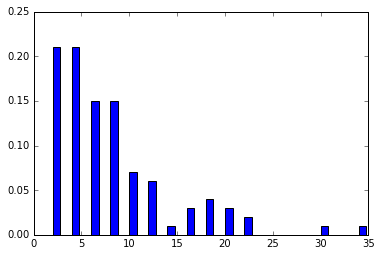

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[  6.00342093e-07,   0.00000000e+00,   6.00342093e-07,
          0.00000000e+00,   9.37465885e-07,   0.00000000e+00,
          5.99998931e-01,   0.00000000e+00,   3.99998931e-01],
       [  0.00000000e+00,   8.34708565e-07,   0.00000000e+00,
          5.34537518e-07,   0.00000000e+00,   5.34537518e-07,
          5.99998931e-01,   2.34366471e-07,   3.99998931e-01],
       [  4.56415361e-07,   0.00000000e+00,   4.56415361e-07,
          0.00000000e+00,   7.12716690e-07,   0.00000000e+00,
          5.99999187e-01,   0.00000000e+00,   3.99999187e-01],
       [  0.00000000e+00,   6.34594533e-07,   0.00000000e+00,
          4.06386853e-07,   0.00000000e+00,   4.06386853e-07,
          5.99999187e-01,   1.78179173e-07,   3.99999187e-01],
       [  3.46993795e-07,   0.00000000e+00,   3.46993795e-07,
          0.00000000e+00,   5.41849137e-07,   0.00000000e+00,
          5.99999382e-01,   0.00000000e+00,   3.99999382e-01]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

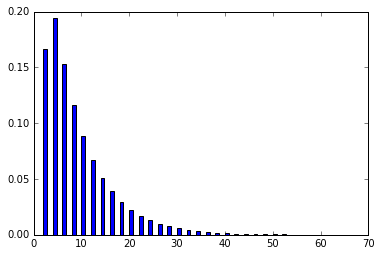

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.6,  0. ,  0.4]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [9]:
N = 5
p = .5
q = (1.0/3.0)
m = .25
n = 1
P = np.array([[0,p,0,p,0,0,0,0,0],[q,0,q,0,q,0,0,0,0],[0,p,0,0,0,p,0,0,0],[q,0,0,0,q,0,q,0,0],[0,m,0,m,0,m,0,m,0],[0,0,q,0,q,0,0,0,q],[0,0,0,0,0,0,n,0,0],[0,0,0,0,q,0,q,0,q],
              [0,0,0,0,0,0,0,0,n]])
phi = np.array([1,0,0,0,0,0,0,0,0])
Steps = 100
Records = 5
Samples = 100
Tolerance = .0001
States_in_Recurrence = [[6],[8]]
printltx(r"The Absorbing Case")
printltx(r"Transition matrix is $P=$"+ltxmtx(P))
printltx(r"Initial distribution $\phi=$"+ltxmtx(phi))
States = P.shape[0]
if phi.shape[0] != States:
    raise Exception("Transition matrix and initial distribution dimensions don't match!")
row_sums = np.sum(P,1)
should_be = np.ones_like(row_sums)
if np.allclose(row_sums,should_be) == False:
    raise Exception("Rows of transition matrix do not all sum to 1!")
simulate_samples(P,phi,Steps,Records,Samples, States_in_Recurrence, Tolerance)
matrix_evolution(P, phi, Steps, Records, States_in_Recurrence, Tolerance)
eigen_future(P,phi)

print



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.51,  0.  ,  0.49],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.51,  0.  ,  0.49],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.51,  0.  ,  0.49],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.51,  0.  ,  0.49],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.51,  0.  ,  0.49]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

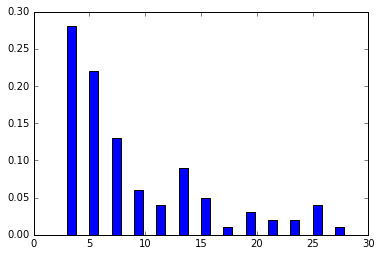

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[  0.00000000e+00,   1.01769638e-06,   0.00000000e+00,
          6.51720753e-07,   0.00000000e+00,   6.51720753e-07,
          4.99998697e-01,   2.85745131e-07,   4.99998697e-01],
       [  5.56472376e-07,   0.00000000e+00,   5.56472376e-07,
          0.00000000e+00,   8.68961005e-07,   0.00000000e+00,
          4.99999009e-01,   0.00000000e+00,   4.99999009e-01],
       [  0.00000000e+00,   7.73712627e-07,   0.00000000e+00,
          4.95476439e-07,   0.00000000e+00,   4.95476439e-07,
          4.99999009e-01,   2.17240251e-07,   4.99999009e-01],
       [  4.23063022e-07,   0.00000000e+00,   4.23063022e-07,
          0.00000000e+00,   6.60635252e-07,   0.00000000e+00,
          4.99999247e-01,   0.00000000e+00,   4.99999247e-01],
       [  0.00000000e+00,   5.88221835e-07,   0.00000000e+00,
          3.76690324e-07,   0.00000000e+00,   3.76690324e-07,
          4.99999247e-01,   1.65158813e-07,   4.99999247e-01]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

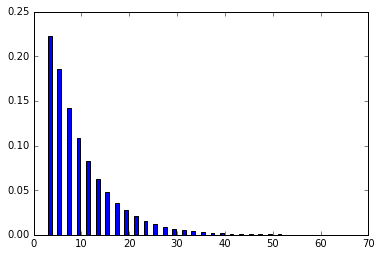

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ,  0.5]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [10]:
N = 5
p = .5
q = (1.0/3.0)
m = .25
n = 1
P = np.array([[0,p,0,p,0,0,0,0,0],[q,0,q,0,q,0,0,0,0],[0,p,0,0,0,p,0,0,0],[q,0,0,0,q,0,q,0,0],[0,m,0,m,0,m,0,m,0],[0,0,q,0,q,0,0,0,q],[0,0,0,0,0,0,n,0,0],[0,0,0,0,q,0,q,0,q],
              [0,0,0,0,0,0,0,0,n]])
phi = np.array([0,1,0,0,0,0,0,0,0])
Steps = 100
Records = 5
Samples = 100
Tolerance = .0001
States_in_Recurrence = [[6],[8]]
printltx(r"The Absorbing Case")
printltx(r"Transition matrix is $P=$"+ltxmtx(P))
printltx(r"Initial distribution $\phi=$"+ltxmtx(phi))
States = P.shape[0]
if phi.shape[0] != States:
    raise Exception("Transition matrix and initial distribution dimensions don't match!")
row_sums = np.sum(P,1)
should_be = np.ones_like(row_sums)
if np.allclose(row_sums,should_be) == False:
    raise Exception("Rows of transition matrix do not all sum to 1!")
simulate_samples(P,phi,Steps,Records,Samples, States_in_Recurrence, Tolerance)
matrix_evolution(P, phi, Steps, Records, States_in_Recurrence, Tolerance)
eigen_future(P,phi)

print

